# Hybridizing process-based models with ML using Jax and Flax 

Arpit Kapoor 2023

In this notebook, we will first train a process-based hydrological model (Simple AWBM) on synthetic streamflow data and then use a Multi-layered perceptron to train hybrid streamflow prediction model.

You can pull the docker image from docker hub with the following command:
```bash
docker pull jsimdare/darenumpyro
```

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import optax 

from tqdm import tqdm

from clu import metrics                # To keep track of training metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses


/build/miniconda3/lib/python3.9/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


### Read synthetic stremflow data from file

In [2]:
raw_data = pd.read_csv(
    os.path.join(
        'project', 'data', 'rr_Data.csv'
    ), index_col=0, parse_dates=True
)
raw_data.head()

,prec,etp,qobs,qsim_excel
date,,,,
1991-01-01,14.1,0.46,2.808,4.100738
1991-01-02,3.7,0.46,4.951,4.571580
1991-01-03,7.1,0.47,4.519,4.210151
1991-01-04,9.3,0.47,4.386,4.413453
1991-01-05,7.1,0.48,5.350,4.694661


We extract features and targets as jax device arrays from dataframe

In [3]:
prec = jnp.array(raw_data['prec'].values) # precipitation
etp = jnp.array(raw_data['etp'].values) # evaporation
q_obs = jnp.array(raw_data['qobs'].values).reshape(-1, 1) # observed discharge
q_date = raw_data.index.values # date

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
#Checks
print('Precipitation: ', prec.shape)
print('Evaporation: ', etp.shape)
print('Observed discharge: ', q_obs.shape)

Precipitation:  (730,)
Evaporation:  (730,)
Observed discharge:  (730, 1)


Create covariate and target vectors

In [5]:
covariates = jnp.stack([prec,etp], axis=1)
targets = q_obs

In [6]:
# Key Generators
root_key = jax.random.PRNGKey(seed=1)
main_key, params_key = jax.random.split(key=root_key, num=2)

## 1. Create an instance of Process-based model

In [7]:
from model.awbm import SimplifiedAWBM

awbm = SimplifiedAWBM(
    S_init=10.0,
    B_init=10.0
)

In [8]:
@struct.dataclass
class Metrics(metrics.Collection):
    loss: metrics.Average.from_output('loss')
    nse: metrics.Average.from_output('nse')

In [9]:
class TrainState(train_state.TrainState):
    metrics: Metrics
    key: jax.random.KeyArray

def create_train_state(module, main_key, params_key, lr, n_features):
    """Creates an initial `TrainState`."""
    
    params = module.init({'params': params_key}, 
                         jnp.ones((1, n_features)))['params']
    
    tx = optax.adam(lr, b1=0.89, b2=0.97)

    return TrainState.create(apply_fn=module.apply, 
                             params=params, tx=tx,
                             key=main_key,
                             metrics=Metrics.empty())

In [10]:
@jax.jit
def train_step(state, batch, targets):
    """Train for a single step."""
    
    def loss_fn(params):
        preds = state.apply_fn({'params': params}, batch)
        loss = optax.l2_loss(preds, targets).mean()
        return loss
    
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    
    return state

In [11]:
@jax.jit
def nse(targets: jnp.ndarray, predictions: jnp.ndarray):
    return 1-(jnp.sum(jnp.square(targets-predictions))/jnp.sum(jnp.square(targets-jnp.mean(targets))))

@jax.jit
def compute_metrics(*, state, batch, targets):
    
    preds = state.apply_fn({'params': state.params}, batch)
    
    loss = optax.l2_loss(preds, targets).mean()
    nse_score = nse(targets, preds)
    
    metric_updates = state.metrics.single_from_model_output(loss=loss,
                                                            nse=nse_score)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    
    return state

In [12]:
def plot_metrics(metrics_history, figsize=(10, 4)):

    metric_list = metrics_history.keys()
    fig, ax = plt.subplots(1, len(metric_list), figsize=figsize)

    for idx, metric in enumerate(metric_list):
        metric_val = jnp.array(metrics_history[metric])
        
        ax[idx].plot(metric_val, color='black')
        ax[idx].set_xlabel('Epoch')
        ax[idx].set_ylabel(metric)

In [13]:
def train(state, covariates, targets, n_epoch):
    """Train function for training Flax modules"""
    pbar = tqdm(range(1, n_epoch+1))

    metrics_history = {'loss': [], 'nse': []}

    for epoch in pbar:
        state = train_step(state, covariates, targets)
        state = compute_metrics(state=state, batch=covariates, targets=targets)
        
        for metric, value in state.metrics.compute().items():
            metrics_history[metric].append(value)
        
        state = state.replace(metrics=state.metrics.empty())

        pbar.set_description(f"""Epoch {epoch}/{n_epoch} loss: {metrics_history['loss'][-1]:.4f}""")

    return state, metrics_history


In [14]:
model_state = create_train_state(awbm, 
                                 main_key=main_key, 
                                 params_key=params_key, 
                                 lr=1e-2,
                                 n_features=covariates.shape[-1])

trained_state, metrics_history = train(model_state, 
                                       covariates, targets, 
                                       n_epoch=150)

Epoch 150/150 loss: 0.5588: 100%|██████████| 150/150 [00:01<00:00, 123.06it/s]


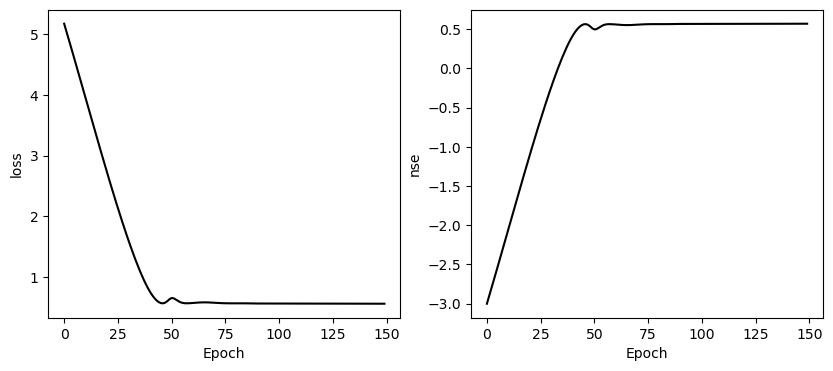

In [15]:
plot_metrics(metrics_history)

In [16]:
def evaluate(module, covariates, q_obs, state=None, params=None):

    if params is None:
        if state is None:
            raise("No params provided!")
        params = state.params
        
    q_hat = module.apply({'params': params}, covariates)
    nse_score = nse(q_obs, q_hat)

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(covariates[:, 0], 'g--', label='precip', alpha=0.40)
    ax.plot(covariates[:, 1], 'y--', label='etp', alpha=0.30)
    ax.plot(q_obs, color='black', label='obs', alpha=1.0)
    ax.plot(q_hat, color='red', label='pred', alpha=0.75)

    ax.set_xlabel('Timestep')
    ax.set_ylabel('Flow (mm/day)')

    ax.annotate(f'NSE: {nse_score:.4f}',
            xy=(0.8, 0.95), xycoords='figure fraction',
            horizontalalignment='right', verticalalignment='top',
            fontsize=12)
    ax.set_title('Streamflow prediction')

    plt.legend()


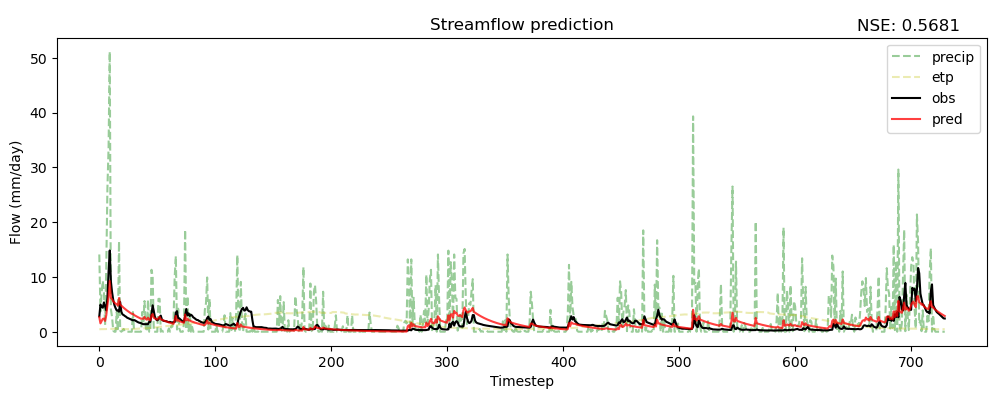

In [17]:
evaluate(awbm, covariates, q_obs, state=trained_state)

## 2. Train Hybrid Model

Now that we have optimised an AWBM model for this data, we will now look at integrating this with an MLP to create a hybrid model. this model takes the output of AWBM and combines it with the covariates to predict streamflow at each timestep. We will optimise for the MLP coefficients and the AWBM coefficients simultaneously.

In [18]:
from model.hybrid import HybridAWBM

hybrid_awbm = HybridAWBM(S_init=10.,
                         B_init=10.,
                         n_layers=2,
                         n_features=[8, 1])

In [19]:
hybrid_state = create_train_state(hybrid_awbm, 
                                  main_key=main_key, 
                                  params_key=params_key, 
                                  lr=1e-2,
                                  n_features=covariates.shape[-1])

trained_hybrid_state, hybrid_metrics_history = train(hybrid_state, 
                                       covariates, targets, 
                                       n_epoch=200)

Epoch 200/200 loss: 0.4608: 100%|██████████| 200/200 [00:01<00:00, 102.80it/s]


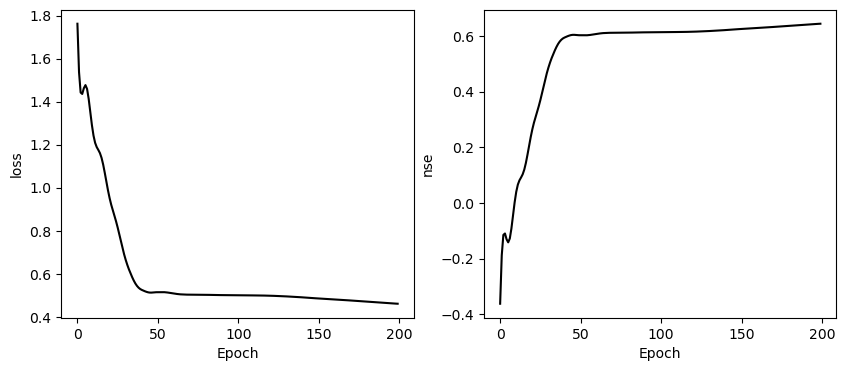

In [20]:
plot_metrics(hybrid_metrics_history)

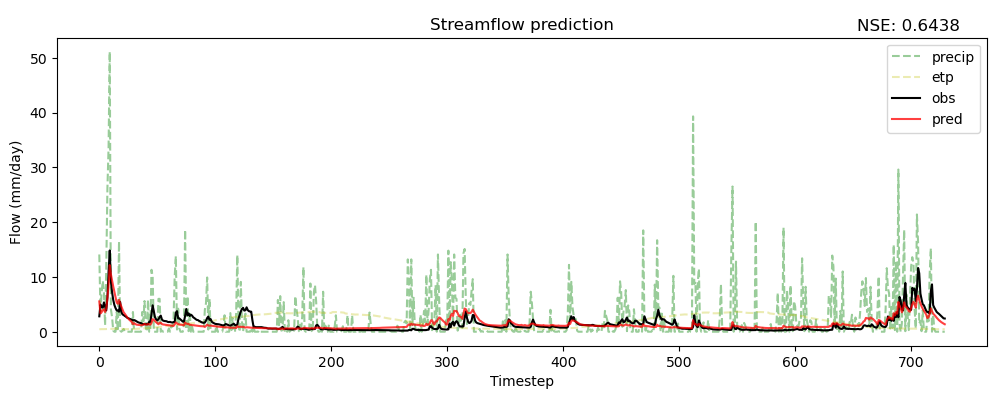

In [21]:
evaluate(hybrid_awbm, covariates, targets, state=trained_hybrid_state)

### Compare the performance of the hybrid model with the AWBM model (NSE)

In [22]:
# Print the overall performance of the awbm vs hybrid model
print('Compare Nash-Sutcliffe Efficiency (NSE) scores')
print(f"AWBM NSE: {metrics_history['nse'][-1]:.4f}")
print(f"Hybrid NSE: {hybrid_metrics_history['nse'][-1]:.4f}")

Compare Nash-Sutcliffe Efficiency (NSE) scores
AWBM NSE: 0.5681
Hybrid NSE: 0.6438


### View the parameters of the model 
Here we can see that the to see how they have been optimised to different values in the AWBM only and the Hybrid model.

In [23]:
# AWBM model optimisation
trained_state.params

FrozenDict({
    BFI: Array([0.9368864], dtype=float32),
    K: Array([0.959092], dtype=float32),
    S_max: Array([1.7505246], dtype=float32),
})

In [24]:
# Hybrid model optimisation
trained_hybrid_state.params

FrozenDict({
    _mlp: {
        layers_0: {
            bias: Array([-0.26803294, -0.1766362 ,  0.        ,  1.042473  , -0.14572665,
                   -0.39263457,  0.4574609 ,  0.44447997], dtype=float32),
            kernel: Array([[ 0.59945965,  0.1791762 , -0.5277055 ,  0.04683558, -0.5709493 ,
                    -0.37014544,  0.24905463,  1.0911913 ],
                   [ 0.30175373,  0.01039166, -0.36756814, -0.10339507,  0.02602776,
                    -1.1354767 ,  0.26878017, -0.14241296],
                   [ 0.03638213,  0.1678972 , -0.71551216, -0.27974123, -0.7304647 ,
                     1.2505251 ,  0.42774367,  0.68157685]], dtype=float32),
        },
        layers_1: {
            bias: Array([0.46221024], dtype=float32),
            kernel: Array([[-0.68423927],
                   [-0.30991226],
                   [ 0.12906006],
                   [ 0.28513026],
                   [-0.29820874],
                   [ 0.5449036 ],
                   [ 0.33327803],